<a href="https://colab.research.google.com/github/Sandesh02/FSM-INT-2022/blob/main/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn import metrics

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

In [26]:
index_names = ['unit', 'cycles']
setting_names = ['OPsetting_1', 'OPsetting_2', 'OPsetting_3']
sensor_names = ['sensor {}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

In [27]:
df1 = pd.read_csv(('/content/drive/My Drive/Colab Notebooks/_train_FD001.txt'), sep='\s+', header=None, names=col_names)

In [28]:
def calculateRUL(df):
    
    #calculating max cycle for each unit
    grouped_by_unit = df.groupby(by="unit")
    max_cycle = grouped_by_unit["cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
df = calculateRUL(df1)
df[index_names+['RUL']]

,unit,cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187
...,...,...,...
20626,100,196,4
20627,100,197,3
20628,100,198,2
20629,100,199,1


In [29]:
delete_columns=['OPsetting_1',
 'OPsetting_2',
 'OPsetting_3',
 'sensor 1',
 'sensor 5',
 'sensor 6',
 'sensor 9',
 'sensor 10',
 'sensor 14',
 'sensor 16',
 'sensor 18',
 'sensor 19']

In [30]:
df = df.drop(columns=delete_columns)
df

,unit,cycles,sensor 2,sensor 3,sensor 4,sensor 7,sensor 8,sensor 11,sensor 12,sensor 13,sensor 15,sensor 17,sensor 20,sensor 21,RUL
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,48.07,519.49,2388.26,8.4956,397,38.49,22.9735,4
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,48.04,519.68,2388.22,8.5139,395,38.30,23.1594,3
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,48.09,520.01,2388.24,8.5646,398,38.44,22.9333,2
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,48.39,519.67,2388.23,8.5389,395,38.29,23.0640,1


In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparation For the Convolutional Neural Network

In [32]:
Train_no=1
engine_id=50


#df=pd.read_csv("/content/drive/My Drive/Colab Notebooks/_train_FD00{}.txt".format(Train_no))
df = df[df['unit']==engine_id]
df = df.drop(columns=['unit'])

df

,cycles,sensor 2,sensor 3,sensor 4,sensor 7,sensor 8,sensor 11,sensor 12,sensor 13,sensor 15,sensor 17,sensor 20,sensor 21,RUL
9711,1,642.12,1582.50,1400.44,553.76,2388.05,47.31,521.97,2388.08,8.4366,394,38.96,23.3947,197
9712,2,642.62,1589.90,1404.14,554.52,2388.02,47.31,522.27,2388.02,8.4211,394,38.91,23.4594,196
9713,3,642.55,1582.75,1403.42,554.26,2388.04,47.41,522.40,2388.04,8.3931,392,38.97,23.3230,195
9714,4,642.61,1586.91,1403.46,554.56,2388.05,47.46,522.25,2388.08,8.4286,393,38.91,23.3886,194
9715,5,642.41,1589.70,1401.43,554.26,2388.05,47.33,522.10,2388.00,8.4295,394,38.98,23.3340,193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9904,194,643.77,1604.93,1423.51,551.41,2388.18,48.16,519.85,2388.19,8.5043,396,38.42,23.0543,4
9905,195,643.33,1605.31,1434.87,551.25,2388.17,48.14,519.33,2388.21,8.5352,395,38.45,23.0191,3
9906,196,643.32,1602.26,1430.01,551.40,2388.19,48.24,519.88,2388.17,8.5034,395,38.45,23.0379,2
9907,197,643.73,1599.94,1432.87,551.18,2388.19,48.22,519.48,2388.20,8.5241,397,38.52,23.0832,1


In [33]:
################################## Scalling the DATA
scaler=MinMaxScaler()
df = scaler.fit_transform(df)
print('Shape of df for engine {}: '.format(engine_id),df.shape)
df

Shape of df for engine 50:  (198, 14)


array([[0.        , 0.14222222, 0.19258561, ..., 0.78571429, 0.82617801,
        1.        ],
       [0.00507614, 0.36444444, 0.42507069, ..., 0.72619048, 0.96167539,
        0.99492386],
       [0.01015228, 0.33333333, 0.20043984, ..., 0.79761905, 0.67602094,
        0.98984772],
       ...,
       [0.98984772, 0.67555556, 0.8133836 , ..., 0.17857143, 0.07895288,
        0.01015228],
       [0.99492386, 0.85777778, 0.74049639, ..., 0.26190476, 0.17382199,
        0.00507614],
       [1.        , 0.90222222, 1.        , ..., 0.1547619 , 0.22701571,
        0.        ]])

In [34]:
################################    Getting into training shape with slidingwindow
features = df[:,0:-1]
target = df[:,-1]

target

array([1.        , 0.99492386, 0.98984772, 0.98477157, 0.97969543,
       0.97461929, 0.96954315, 0.96446701, 0.95939086, 0.95431472,
       0.94923858, 0.94416244, 0.93908629, 0.93401015, 0.92893401,
       0.92385787, 0.91878173, 0.91370558, 0.90862944, 0.9035533 ,
       0.89847716, 0.89340102, 0.88832487, 0.88324873, 0.87817259,
       0.87309645, 0.8680203 , 0.86294416, 0.85786802, 0.85279188,
       0.84771574, 0.84263959, 0.83756345, 0.83248731, 0.82741117,
       0.82233503, 0.81725888, 0.81218274, 0.8071066 , 0.80203046,
       0.79695431, 0.79187817, 0.78680203, 0.78172589, 0.77664975,
       0.7715736 , 0.76649746, 0.76142132, 0.75634518, 0.75126904,
       0.74619289, 0.74111675, 0.73604061, 0.73096447, 0.72588832,
       0.72081218, 0.71573604, 0.7106599 , 0.70558376, 0.70050761,
       0.69543147, 0.69035533, 0.68527919, 0.68020305, 0.6751269 ,
       0.67005076, 0.66497462, 0.65989848, 0.65482234, 0.64974619,
       0.64467005, 0.63959391, 0.63451777, 0.62944162, 0.62436

In [35]:
win_length = 25   ######### Sliding Window Length
feature_num = 13  ######### Total number of features

ts_generator = TimeseriesGenerator(features,target,length=win_length,sampling_rate=1,batch_size=1)

In [36]:
ts_generator[0]

(array([[[0.        , 0.14222222, 0.19258561, 0.1151375 , 0.68617021,
          0.26086957, 0.16216216, 0.84615385, 0.39285714, 0.4085183 ,
          0.57142857, 0.78571429, 0.82617801],
         [0.00507614, 0.36444444, 0.42507069, 0.21022873, 0.88829787,
          0.13043478, 0.16216216, 0.94230769, 0.17857143, 0.31553689,
          0.57142857, 0.72619048, 0.96167539],
         [0.01015228, 0.33333333, 0.20043984, 0.19172449, 0.81914894,
          0.2173913 , 0.25225225, 0.98397436, 0.25      , 0.14757049,
          0.28571429, 0.79761905, 0.67602094],
         [0.01522843, 0.36      , 0.33113415, 0.19275251, 0.89893617,
          0.26086957, 0.2972973 , 0.93589744, 0.39285714, 0.36052789,
          0.42857143, 0.72619048, 0.81340314],
         [0.02030457, 0.27111111, 0.41878731, 0.14058083, 0.81914894,
          0.26086957, 0.18018018, 0.88782051, 0.10714286, 0.36592681,
          0.57142857, 0.80952381, 0.69905759],
         [0.02538071, 0.29333333, 0.28180961, 0.16628116, 0.65159

In [37]:
print('Shape of the input features',np.shape(ts_generator[0][0]))
print((ts_generator[0][0]))
print('\n')
print('Shape of the output variable',np.shape(ts_generator[0][1]))
print(ts_generator[0][1])

Shape of the input features (1, 25, 13)
[[[0.         0.14222222 0.19258561 0.1151375  0.68617021 0.26086957
   0.16216216 0.84615385 0.39285714 0.4085183  0.57142857 0.78571429
   0.82617801]
  [0.00507614 0.36444444 0.42507069 0.21022873 0.88829787 0.13043478
   0.16216216 0.94230769 0.17857143 0.31553689 0.57142857 0.72619048
   0.96167539]
  [0.01015228 0.33333333 0.20043984 0.19172449 0.81914894 0.2173913
   0.25225225 0.98397436 0.25       0.14757049 0.28571429 0.79761905
   0.67602094]
  [0.01522843 0.36       0.33113415 0.19275251 0.89893617 0.26086957
   0.2972973  0.93589744 0.39285714 0.36052789 0.42857143 0.72619048
   0.81340314]
  [0.02030457 0.27111111 0.41878731 0.14058083 0.81914894 0.26086957
   0.18018018 0.88782051 0.10714286 0.36592681 0.57142857 0.80952381
   0.69905759]
  [0.02538071 0.29333333 0.28180961 0.16628116 0.65159574 0.08695652
   0.31531532 0.71474359 0.         0.23275345 0.14285714 0.67857143
   0.62513089]
  [0.03045685 0.25333333 0.26390198 0.16396

In [38]:
X=[]
y=[]

x_temp, y_temp = ts_generator[0]
X.append(x_temp.reshape(x_temp.shape[1],x_temp.shape[2],1))
y.append(y_temp)

print(X)
print(y)

[array([[[0.        ],
        [0.14222222],
        [0.19258561],
        [0.1151375 ],
        [0.68617021],
        [0.26086957],
        [0.16216216],
        [0.84615385],
        [0.39285714],
        [0.4085183 ],
        [0.57142857],
        [0.78571429],
        [0.82617801]],

       [[0.00507614],
        [0.36444444],
        [0.42507069],
        [0.21022873],
        [0.88829787],
        [0.13043478],
        [0.16216216],
        [0.94230769],
        [0.17857143],
        [0.31553689],
        [0.57142857],
        [0.72619048],
        [0.96167539]],

       [[0.01015228],
        [0.33333333],
        [0.20043984],
        [0.19172449],
        [0.81914894],
        [0.2173913 ],
        [0.25225225],
        [0.98397436],
        [0.25      ],
        [0.14757049],
        [0.28571429],
        [0.79761905],
        [0.67602094]],

       [[0.01522843],
        [0.36      ],
        [0.33113415],
        [0.19275251],
        [0.89893617],
        [0.26086957],
   

In [39]:
def Data_format_conversion(Train_no,engine_id):    
    
    import pandas as pd
    import numpy as np
    df=pd.read_csv("/content/drive/My Drive/Colab Notebooks/Processed_Train_00{}.csv".format(Train_no))
    df = df[df['ID']==engine_id]
    df = df.drop(columns=['ID'])

    ################################## Scalling the DATA
    scaler=MinMaxScaler()
    df = scaler.fit_transform(df)
    print('Shape of df for engine {}: '.format(engine_id),df.shape)

    ################################    Getting into training shape with slidingwindow
    features = df[:,0:-1]
    target = df[:,-1]



    ts_generator = TimeseriesGenerator(features,target,length=win_length,sampling_rate=1,batch_size=1)

    ################################ Changing the shape of input to (no of smaples,window_length,features)
    X=[]
    y=[]
    for i in range(len(ts_generator)):
        x_temp, y_temp = ts_generator[i]
        X.append(x_temp.reshape(x_temp.shape[1],x_temp.shape[2],1))
        y.append(y_temp)

    X=np.array(X)  
    y=np.array(y)  
    
    return(X,y,scaler,features)

# Training the CNN Model

In [40]:
import tensorflow as tf
win_length = 25   ######### Sliding Window Length
feature_num = 13  ######### Total number of features

model=Sequential()
# CNN
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(win_length,feature_num,1)))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_squared_error'])
model.summary()
# from sklearn.metrics import matthews_corrcoef
# model = Sequential()

# model.add(tf.keras.layers.Conv1D(32, 8, padding='same',input_shape=(win_length,feature_num),activation='relu'))
# model.add(tf.keras.layers.MaxPooling1D(2, padding='same'))
# model.add(tf.keras.layers.Conv1D(64, 8, padding='same', activation='relu'))
# model.add(tf.keras.layers.MaxPooling1D(2, padding='same'))
# model.add(tf.keras.layers.Conv1D(128, 8, padding='same', activation='relu'))
# model.add(tf.keras.layers.MaxPooling1D(2, padding='same'))
# model.add(tf.keras.layers.Conv1D(256, 8, padding='same', activation='relu'))
# model.add(tf.keras.layers.LSTM(64, dropout =0.2 ))
# model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy',matthews_corrcoef])

# model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 23, 11, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 9, 64)         18496     
                                                                 
 conv2d_4 (Conv2D)           (None, 19, 7, 128)        73856     
                                                                 
 flatten_1 (Flatten)         (None, 17024)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17025     
                                                                 
Total params: 109,697
Trainable params: 109,697
Non-trainable params: 0
_________________________________________________________________


In [41]:

###############################  Fitting the training data with CNN
Train_no=1
for engine_no in range(1,50):    
    X,y,scaler,features=Data_format_conversion(Train_no,engine_no) 
    
    model.fit(X,y,steps_per_epoch=5,epochs=15,shuffle=False,verbose=0)
    

Shape of df for engine 1:  (192, 14)
Shape of df for engine 2:  (287, 14)
Shape of df for engine 3:  (179, 14)
Shape of df for engine 4:  (189, 14)
Shape of df for engine 5:  (269, 14)
Shape of df for engine 6:  (188, 14)
Shape of df for engine 7:  (259, 14)
Shape of df for engine 8:  (150, 14)
Shape of df for engine 9:  (201, 14)
Shape of df for engine 10:  (222, 14)
Shape of df for engine 11:  (240, 14)
Shape of df for engine 12:  (170, 14)
Shape of df for engine 13:  (163, 14)
Shape of df for engine 14:  (180, 14)
Shape of df for engine 15:  (207, 14)
Shape of df for engine 16:  (209, 14)
Shape of df for engine 17:  (276, 14)
Shape of df for engine 18:  (195, 14)
Shape of df for engine 19:  (158, 14)
Shape of df for engine 20:  (234, 14)
Shape of df for engine 21:  (195, 14)
Shape of df for engine 22:  (202, 14)
Shape of df for engine 23:  (168, 14)
Shape of df for engine 24:  (147, 14)
Shape of df for engine 25:  (230, 14)
Shape of df for engine 26:  (199, 14)
Shape of df for engin

# Loading the saved model

In [42]:
from keras.models import load_model
 
# load model
#model = load_model('model_1.h5')

# Predict on Training data

In [43]:
Train_no=1
engine_id = 1
X,y,scaler,features=Data_format_conversion(Train_no,engine_id) 

Shape of df for engine 1:  (192, 14)


In [44]:
X.shape

(167, 25, 13, 1)

In [45]:
prediction=model.predict(X) ######### prediction on trained data
np.shape(prediction)

(167, 1)

In [46]:
len(features)

192

In [47]:
rev_trans =pd.concat([pd.DataFrame(features[win_length:]),pd.DataFrame(prediction)],axis=1)
rev_trans

,0,1,2,3,4,5,6,7,8,9,10,11,12,0
0,0.130890,0.180,0.412356,0.063945,0.800469,0.21875,0.176923,0.825826,0.236842,0.374110,0.500,0.619048,0.842913,0.875439
1,0.136126,0.292,0.462284,0.212121,0.791080,0.06250,0.261538,0.741742,0.421053,0.235599,0.375,0.773810,0.902606,0.870463
2,0.141361,0.256,0.188218,0.142527,0.934272,0.37500,0.292308,0.912913,0.289474,0.414887,0.000,0.797619,0.601183,0.859965
3,0.146597,0.080,0.259698,0.190293,0.833333,0.15625,0.161538,0.864865,0.236842,0.328155,0.375,0.702381,0.740898,0.851953
4,0.151832,0.196,0.571839,0.064201,0.861502,0.21875,0.284615,0.798799,0.078947,0.247896,0.000,0.845238,0.835705,0.844105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,0.979058,0.816,0.890086,0.749872,0.291080,0.96875,0.746154,0.078078,0.684211,0.987055,0.750,0.202381,0.000000,0.021423
163,0.984293,0.988,0.667026,0.884181,0.000000,0.84375,0.807692,0.015015,0.947368,0.971521,0.625,0.166667,0.284421,0.017965
164,0.989529,0.772,0.776580,0.831279,0.138498,0.90625,1.000000,0.153153,1.000000,0.997411,1.000,0.178571,0.200887,0.011066
165,0.994764,0.652,0.889368,0.826656,0.051643,0.87500,0.861538,0.012012,0.868421,0.965696,0.500,0.130952,0.315468,0.002097


In [48]:
rev_trans = scaler.inverse_transform(rev_trans)######## Transforming back to original scale
rev_trans =pd.DataFrame(rev_trans)
rev_trans

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,26.0,642.16,1589.08,1396.07,554.11,2388.07,47.26,522.28,2388.06,8.4260,394.0,38.86,23.4149,167.208790
1,27.0,642.44,1590.47,1401.84,554.07,2388.02,47.37,522.00,2388.13,8.4046,393.0,38.99,23.4472,166.258390
2,28.0,642.35,1582.84,1399.13,554.68,2388.12,47.41,522.57,2388.08,8.4323,390.0,39.01,23.2841,164.253400
3,29.0,641.91,1584.83,1400.99,554.25,2388.05,47.24,522.41,2388.06,8.4189,393.0,38.93,23.3597,162.723097
4,30.0,642.20,1593.52,1396.08,554.37,2388.07,47.40,522.19,2388.00,8.4065,390.0,39.05,23.4110,161.224033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,188.0,643.75,1602.38,1422.78,551.94,2388.31,48.00,519.79,2388.23,8.5207,396.0,38.51,22.9588,4.091792
163,189.0,644.18,1596.17,1428.01,550.70,2388.27,48.08,519.58,2388.33,8.5183,395.0,38.48,23.1127,3.431407
164,190.0,643.64,1599.22,1425.95,551.29,2388.29,48.33,520.04,2388.35,8.5223,398.0,38.49,23.0675,2.113555
165,191.0,643.34,1602.36,1425.77,550.92,2388.28,48.15,519.57,2388.30,8.5174,394.0,38.45,23.1295,0.400483


In [49]:
    
df=pd.read_csv("/content/drive/My Drive/Colab Notebooks/Processed_Train_00{}.csv".format(Train_no))
df = df[df['ID']==engine_id]
df_actual = df.drop(columns=['ID'])
df_actual

,Cycle,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21,RUL
0,1,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,2,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,3,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,4,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,5,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,188,643.75,1602.38,1422.78,551.94,2388.31,48.00,519.79,2388.23,8.5207,396,38.51,22.9588,4
188,189,644.18,1596.17,1428.01,550.70,2388.27,48.08,519.58,2388.33,8.5183,395,38.48,23.1127,3
189,190,643.64,1599.22,1425.95,551.29,2388.29,48.33,520.04,2388.35,8.5223,398,38.49,23.0675,2
190,191,643.34,1602.36,1425.77,550.92,2388.28,48.15,519.57,2388.30,8.5174,394,38.45,23.1295,1


In [50]:
print('RMSE on This set:', np.sqrt(metrics.mean_squared_error(df_actual['RUL'][win_length:],rev_trans[13])))

RMSE on This set: 4.013404041850788


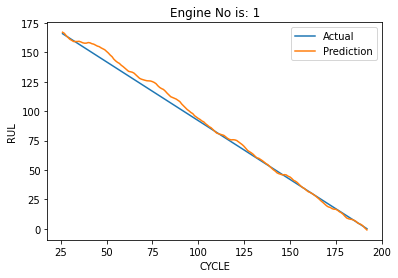

In [51]:
plt.plot(df_actual['Cycle'][win_length:],df_actual['RUL'][win_length:])
plt.plot(rev_trans[0],rev_trans[13])
plt.ylabel('RUL')
plt.xlabel('CYCLE')
plt.title('Engine No is: {}'.format(engine_id))
plt.legend([ 'Actual','Prediction'], loc='upper right')
plt.show()
print('\n')

Shape of df for engine 41:  (216, 14)
RMSE on This set: 3.6798723036457996


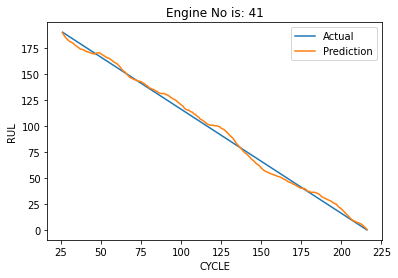



Shape of df for engine 9:  (201, 14)
RMSE on This set: 6.143307352922462


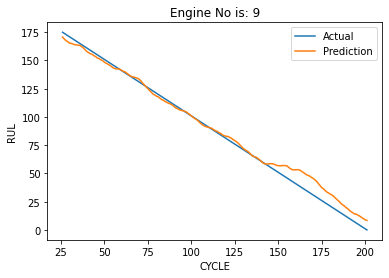



Shape of df for engine 47:  (214, 14)
RMSE on This set: 2.766888607255957


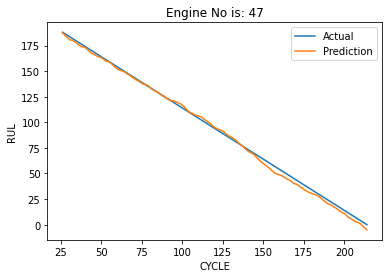



Shape of df for engine 9:  (201, 14)
RMSE on This set: 6.143307352922462


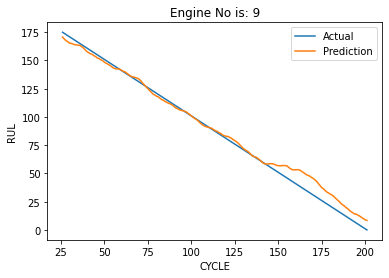



Shape of df for engine 5:  (269, 14)
RMSE on This set: 3.9090967851027516


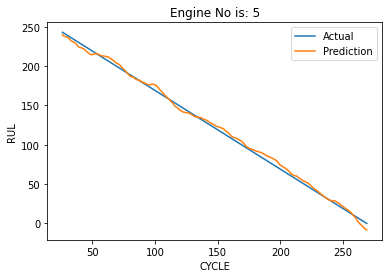



Shape of df for engine 27:  (156, 14)
RMSE on This set: 3.3948397996147763


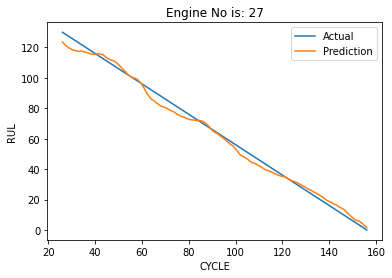



Shape of df for engine 18:  (195, 14)
RMSE on This set: 9.581050470774011


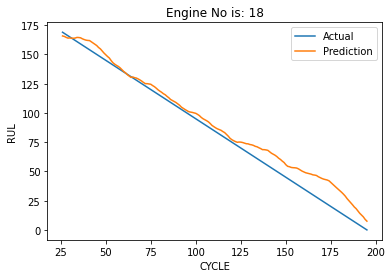



Shape of df for engine 39:  (128, 14)
RMSE on This set: 8.75978486646916


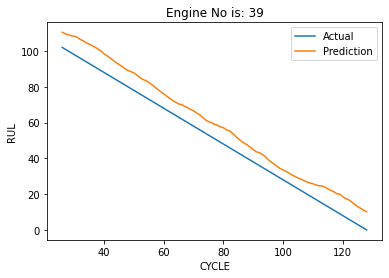



Shape of df for engine 2:  (287, 14)
RMSE on This set: 4.805192781026773


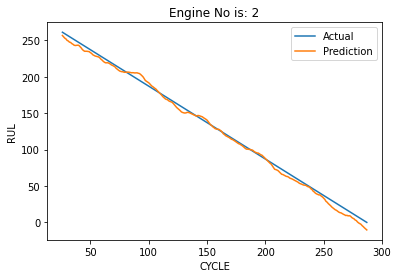



Shape of df for engine 8:  (150, 14)
RMSE on This set: 2.093098587682137


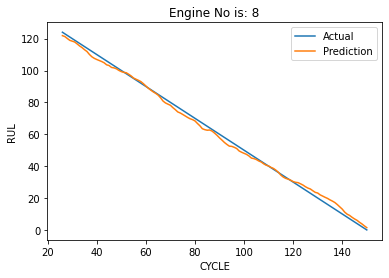



Shape of df for engine 21:  (195, 14)
RMSE on This set: 9.222457907078441


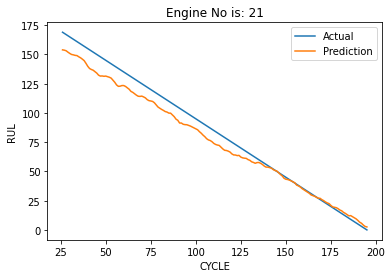



Shape of df for engine 44:  (192, 14)
RMSE on This set: 3.122414009924117


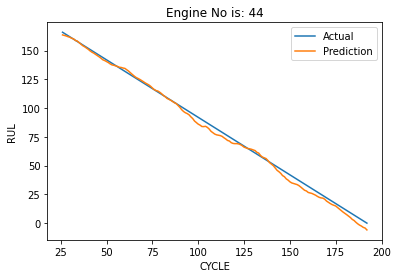



Shape of df for engine 33:  (200, 14)
RMSE on This set: 6.783206347097872


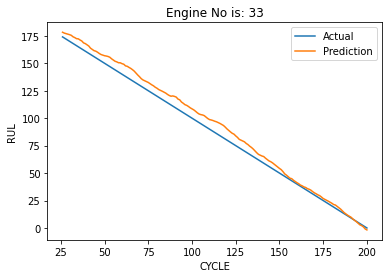



Shape of df for engine 21:  (195, 14)
RMSE on This set: 9.222457907078441


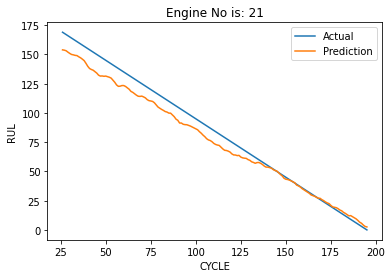



Shape of df for engine 9:  (201, 14)
RMSE on This set: 6.143307352922462


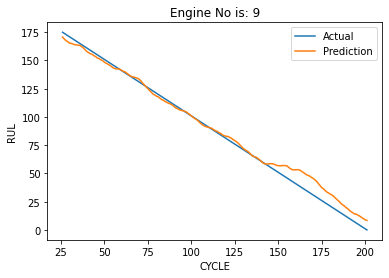



Shape of df for engine 32:  (191, 14)
RMSE on This set: 3.68447675861681


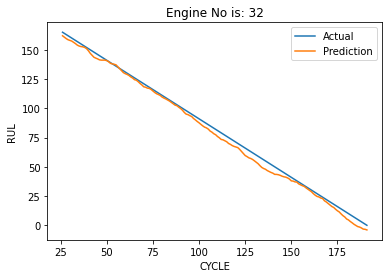



Shape of df for engine 43:  (207, 14)
RMSE on This set: 6.855262222265028


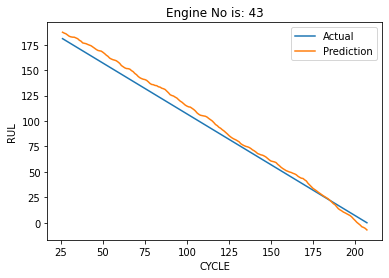



Shape of df for engine 28:  (165, 14)
RMSE on This set: 7.552226739483791


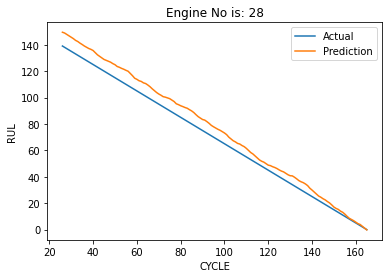



Shape of df for engine 26:  (199, 14)
RMSE on This set: 10.867521948819592


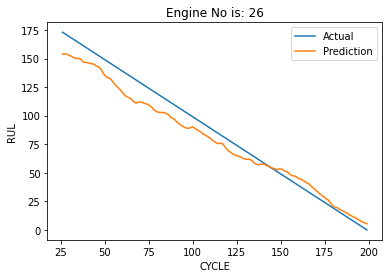



Shape of df for engine 14:  (180, 14)
RMSE on This set: 9.584891936646475


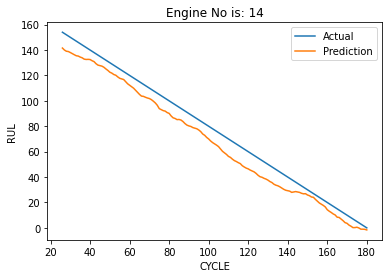



Shape of df for engine 18:  (195, 14)
RMSE on This set: 9.581050470774011


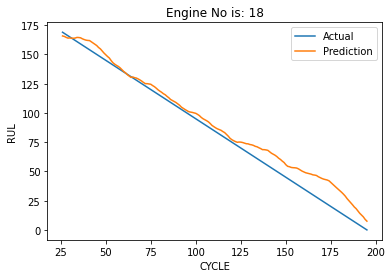



Shape of df for engine 33:  (200, 14)
RMSE on This set: 6.783206347097872


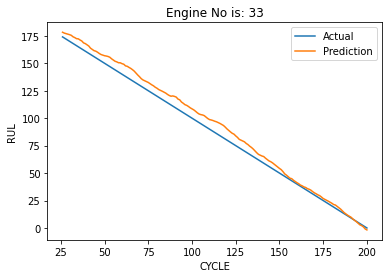



Shape of df for engine 48:  (231, 14)
RMSE on This set: 7.551366093043251


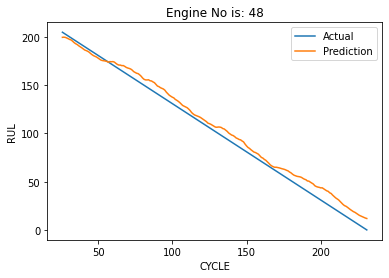



Shape of df for engine 39:  (128, 14)
RMSE on This set: 8.75978486646916


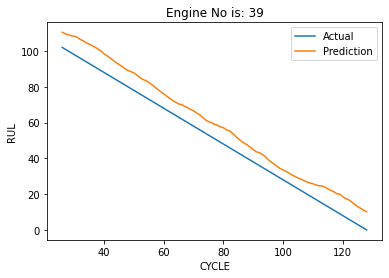



Shape of df for engine 44:  (192, 14)
RMSE on This set: 3.122414009924117


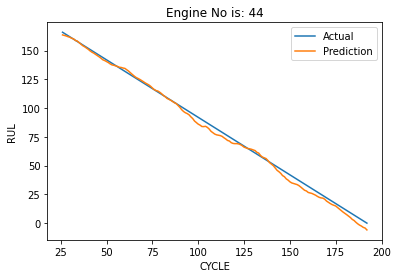

In [52]:
Train_no=1

m = np.random.randint(low=1,high=50,size=25) 

for i in m:    
    engine_id=i
    X,y,scaler,features=Data_format_conversion(Train_no,engine_id) 

    prediction=model.predict(X) ######### prediction on trained data
    rev_trans =pd.concat([pd.DataFrame(features[win_length:]),pd.DataFrame(prediction)],axis=1)
    rev_trans = scaler.inverse_transform(rev_trans)######## Transforming back to original scale
    rev_trans =pd.DataFrame(rev_trans)

    
    df=pd.read_csv("/content/drive/My Drive/Colab Notebooks/Processed_Train_00{}.csv".format(Train_no))
    df = df[df['ID']==engine_id]
    df_actual = df.drop(columns=['ID'])


    print('RMSE on This set:', np.sqrt(metrics.mean_squared_error(df_actual['RUL'][win_length:],rev_trans[13])))

    plt.plot(df_actual['Cycle'][win_length:],df_actual['RUL'][win_length:])
    plt.plot(rev_trans[0],rev_trans[13])
    plt.ylabel('RUL')
    plt.xlabel('CYCLE')
    plt.title('Engine No is: {}'.format(engine_id))
    plt.legend([ 'Actual','Prediction'], loc='upper right')
    plt.show()
    print('\n')

# Predict on Test data

In [54]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


Shape of df for engine 91:  (135, 14)
RMSE on This set: 2.259873981522398
R2 on This set: 0.9949347578354952


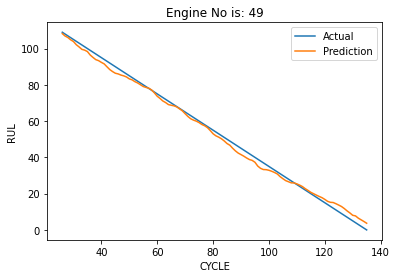



Shape of df for engine 69:  (362, 14)
RMSE on This set: 13.35216468764118
R2 on This set: 0.9811622673451086


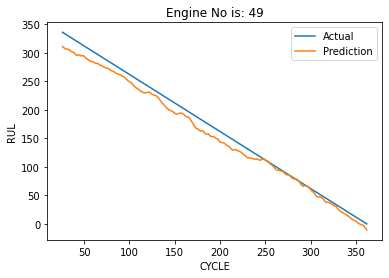



Shape of df for engine 77:  (154, 14)
RMSE on This set: 2.2156060057992724
R2 on This set: 0.9964599206925958


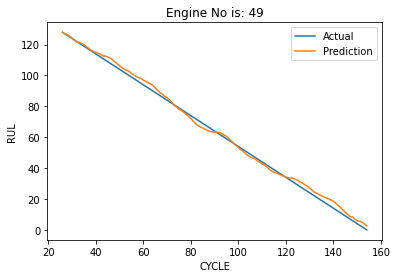



Shape of df for engine 84:  (267, 14)
RMSE on This set: 15.304817515075763
R2 on This set: 0.952002983623837


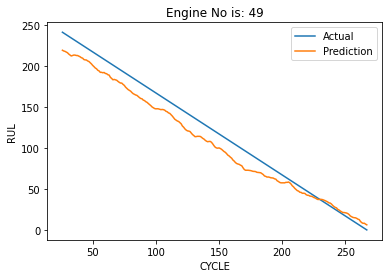



Shape of df for engine 93:  (155, 14)
RMSE on This set: 6.840989596799658
R2 on This set: 0.9667678759712259


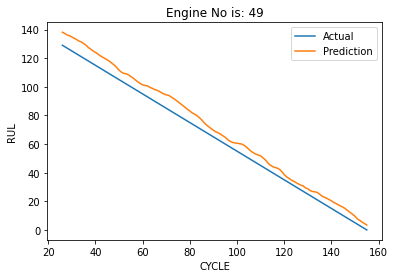



Shape of df for engine 68:  (199, 14)
RMSE on This set: 10.516394683418845
R2 on This set: 0.9561640070801228


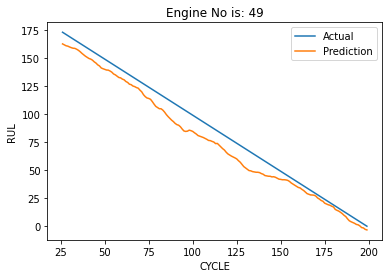



Shape of df for engine 83:  (293, 14)
RMSE on This set: 5.179317564461677
R2 on This set: 0.995518093574447


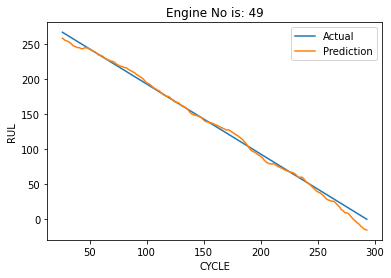



Shape of df for engine 79:  (199, 14)
RMSE on This set: 3.437783777414972
R2 on This set: 0.9953155974367269


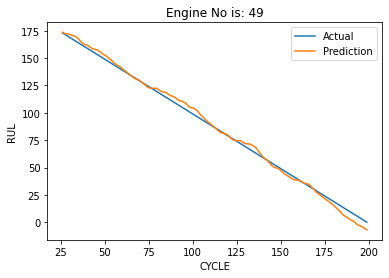



Shape of df for engine 52:  (213, 14)
RMSE on This set: 7.153588726211191
R2 on This set: 0.9826249616624138


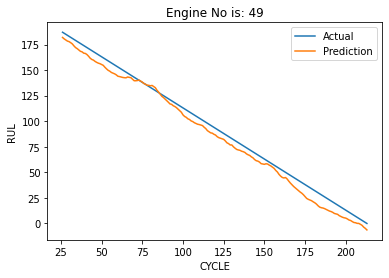



Shape of df for engine 64:  (283, 14)
RMSE on This set: 5.767798699006814
R2 on This set: 0.9940025235943816


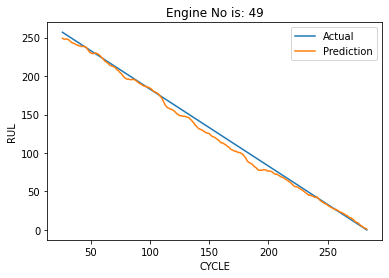



Shape of df for engine 67:  (313, 14)
RMSE on This set: 7.978756691551723
R2 on This set: 0.9907897387348447


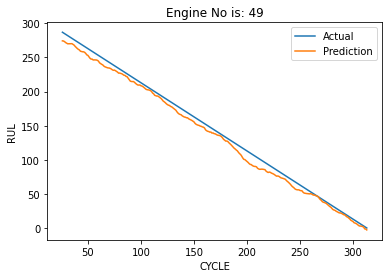



Shape of df for engine 81:  (240, 14)
RMSE on This set: 5.383285430728097
R2 on This set: 0.992476697292656


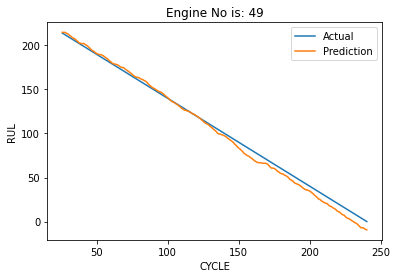



Shape of df for engine 51:  (213, 14)
RMSE on This set: 7.365077374629666
R2 on This set: 0.9815824243326434


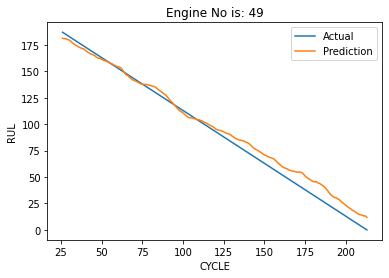



Shape of df for engine 95:  (283, 14)
RMSE on This set: 3.6667565343046324
R2 on This set: 0.9975761122277783


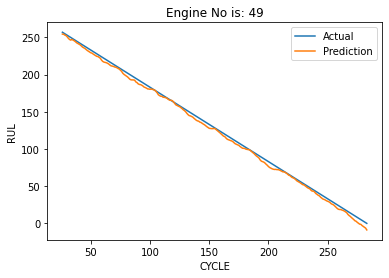



Shape of df for engine 77:  (154, 14)
RMSE on This set: 2.2156060057992724
R2 on This set: 0.9964599206925958


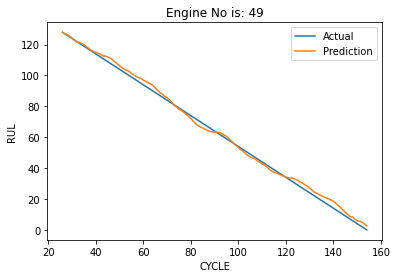



Shape of df for engine 98:  (156, 14)
RMSE on This set: 2.7264342243515522
R2 on This set: 0.9948017877064927


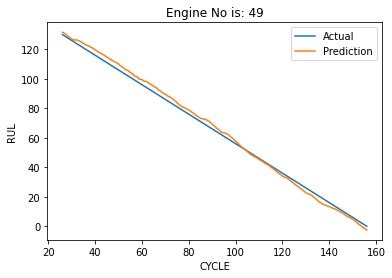



Shape of df for engine 97:  (202, 14)
RMSE on This set: 8.186420163941305
R2 on This set: 0.974329363470154


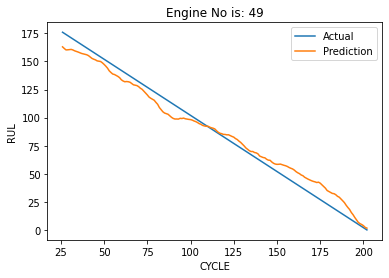



Shape of df for engine 55:  (193, 14)
RMSE on This set: 11.35648263871706
R2 on This set: 0.9451640018750033


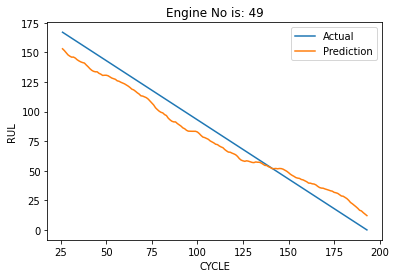



Shape of df for engine 51:  (213, 14)
RMSE on This set: 7.365077374629666
R2 on This set: 0.9815824243326434


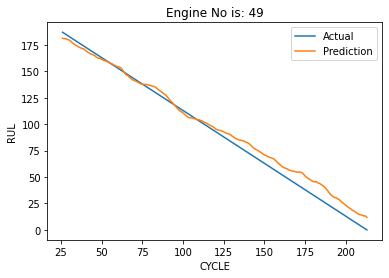



Shape of df for engine 78:  (231, 14)
RMSE on This set: 6.4991558403560905
R2 on This set: 0.9880554184129418


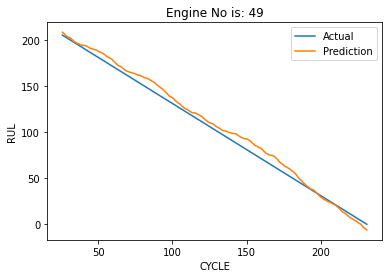



Shape of df for engine 79:  (199, 14)
RMSE on This set: 3.437783777414972
R2 on This set: 0.9953155974367269


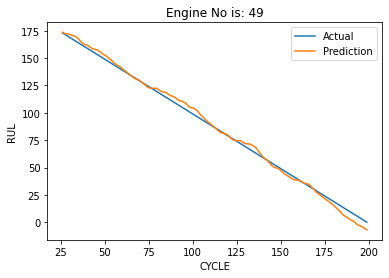



Shape of df for engine 73:  (213, 14)
RMSE on This set: 9.39050770306222
R2 on This set: 0.9700597114264423


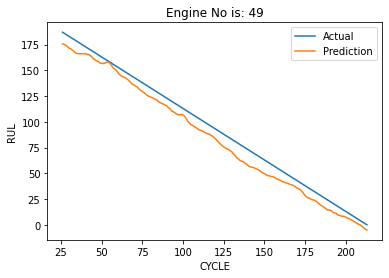



Shape of df for engine 66:  (202, 14)
RMSE on This set: 10.554129570071812
R2 on This set: 0.9573328711765076


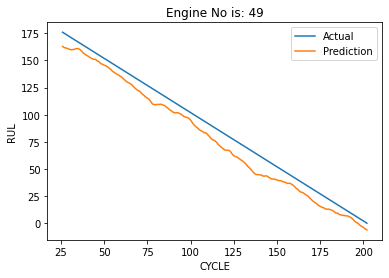



Shape of df for engine 83:  (293, 14)
RMSE on This set: 5.179317564461677
R2 on This set: 0.995518093574447


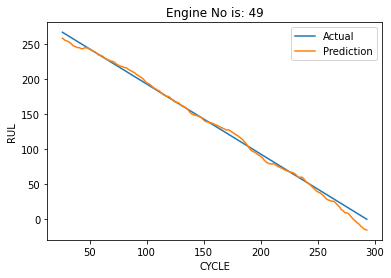



Shape of df for engine 88:  (213, 14)
RMSE on This set: 2.410373741059719
R2 on This set: 0.9980273655643527


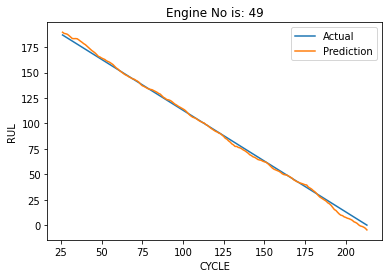

In [55]:
Train_no=1

n = np.random.randint(low=51,high=100,size=25) 

for i in n:    
    engine_id=i
    X,y,scaler,features=Data_format_conversion(Train_no,engine_id) 

    prediction=model.predict(X) ######### prediction on trained data
    rev_trans =pd.concat([pd.DataFrame(features[win_length:]),pd.DataFrame(prediction)],axis=1)
    rev_trans = scaler.inverse_transform(rev_trans)######## Transforming back to original scale
    rev_trans =pd.DataFrame(rev_trans)

    df=pd.read_csv("/content/drive/My Drive/Colab Notebooks/Processed_Train_00{}.csv".format(Train_no))
    df = df[df['ID']==engine_id]
    df_actual = df.drop(columns=['ID'])


    print('RMSE on This set:', np.sqrt(metrics.mean_squared_error(df_actual['RUL'][win_length:],rev_trans[13])))
    print('R2 on This set:', r2_score(df_actual['RUL'][win_length:],rev_trans[13]))


    plt.plot(df_actual['Cycle'][win_length:],df_actual['RUL'][win_length:])
    plt.plot(rev_trans[0],rev_trans[13])
    plt.ylabel('RUL')
    plt.xlabel('CYCLE')
    plt.title('Engine No is: {}'.format(engine_no))
    plt.legend([ 'Actual','Prediction'], loc='upper right')
    plt.show()
    print('\n')

In [ ]:
# save model and architecture to single file
#model.save("model_1.h5")
#print("Saved model to disk")